#0. Instructions

Below this Inference mode is created for basic understanding of the best model- **ResnetGRU_2**

Dataset: https://www.crcv.ucf.edu/data/UCF101.php

To run this two 3 things should be uploaded
- UCF101 Dataset( smaller one with 10 classes) is shared in zip file 
- UCF101 Dataset with annotation path (you can take it from the link above)
- The model path from the shared zip file (model_ResGRU2.pth)

You can also upload everything into google drive and mount it- called *INM705_Dataset*

# 1. Import necesarry packages

In [ ]:
#Load the dataset and show couple of videos
#Import necessary packages

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import UCF101
from torchvision.transforms import Lambda
from IPython.display import Video,display, FileLink, HTML

from torchvision.io import write_video


import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models


In [ ]:
!pip install av

In [ ]:
#Load your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive/ My Drive/INM705_Dataset/
!ls

/content/drive/ My Drive/INM705_Dataset
model_ResGRU2.pth  sv-en  UCF-101  ucfTrainTestlist


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print ('Device set to {0}'.format(device))

Device set to cpu


# 2. Include utility function to show videos

In [ ]:
#Function that shows the video frames
def show_video_frames(inputs):
    num_frames = inputs.shape[1]  # Assuming inputs are shaped [batch, frames, channels, height, width]
    fig, axs = plt.subplots(1, num_frames, figsize=(15, 3))
    for i in range(num_frames):
        axs[i].imshow(inputs[0, i].permute(1, 2, 0).numpy(), aspect='auto')
        axs[i].axis('off')
    plt.show()


def show_frames(frames, num_frames=5): #You can play around with num_frames, it should be better if its same as 'frames_per_clip'
    """ Display the first 'num_frames' frames of a video tensor """
    fig, axs = plt.subplots(1, num_frames, figsize=(40, 2))
    for i, frame in enumerate(frames[:num_frames]):
        frame = frame.permute(1, 2, 0)  # CHW to HWC
        axs[i].imshow(frame.numpy())
        axs[i].axis('off')
    plt.show()


def custom_collate_fn(batch): # This custom code is taken from https://github.com/pytorch/vision/issues/2265
    filtered_batch = []       # The purpose of this code is to filter out the audio data from the batch
    for video, _, label in batch:
        filtered_batch.append((video, label))

    return torch.utils.data.dataloader.default_collate(filtered_batch)

transform = transforms.Compose([

    transforms.Lambda(lambda x: x / 255.),    # scale in [0, 1]
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2) ), # reshape into (T, C, H, W) # T number of frames in the video clip , C is Channel, H is Height, W is Width
    transforms.Resize((240, 320)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

             ])

In [ ]:
paths = 'UCF-101'
annotation_path = 'ucfTrainTestlist'
frames_per_clip = 5
step_between_clips = 1

test_dataset = UCF101(paths, annotation_path, frames_per_clip,step_between_clips, fold=2, train=False, transform = transform)

  0%|          | 0/81 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 81/81 [01:07<00:00,  2.54it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 81/81 [01:07<00:00,  1.19it/s]



For this inference, we only take first **10 labels** form the actual dataset for simplicity, otherwise it tooks a quite long time to upload every videos from the actual dataset







In [ ]:
ucf101_labels = {
    0: "ApplyEyeMakeup",
    1: "ApplyLipstick",
    2: "Archery",
    3: "BabyCrawling",
    4: "BalanceBeam",
    5: "BandMarching",
    6: "BaseballPitch",
    7: "Basketball",
    8: "BasketballDunk",
    9: "BenchPress",
    }

- Above, it shows the a corresponding labels
- Below, it shows the a simple test video that will be feed into model(randomly)



/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


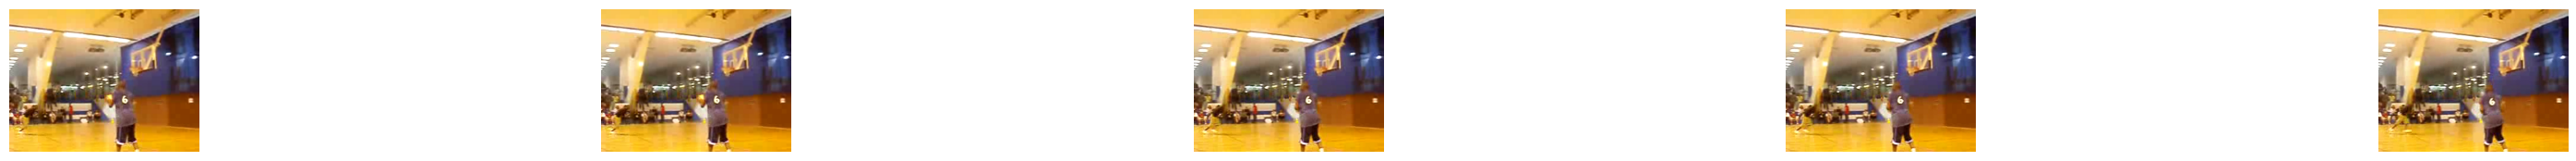

Corresponding label of the video: Basketball


In [ ]:
test_loader = DataLoader(test_dataset,64,num_workers=0, shuffle=True,collate_fn=custom_collate_fn)
#Shuffle is True, so it will randomly select from the dataset, you can change it to False

# Load a single random batch from the DataLoader
for batch in test_loader:
    video_tensors, labels = batch
    video_tensor = video_tensors[0] # Take the first video in the batch
    label = labels[0].item()
    show_frames(video_tensor)
    print(f'Corresponding label of the video: {ucf101_labels[label]}')
    break

#3. Model Architecture

In [ ]:
class ResNetGRU(nn.Module):

    def __init__(self, num_classes,checkpoint_file=None):
        super(ResNetGRU, self).__init__()


        #Load the pretained model
        if checkpoint_file is not None:
            state_dict = torch.load(checkpoint_file)
            print('Model loaded from checkpoint,hopefully :)')
        else:
            state_dict = models.resnet50(pretrained=False).state_dict()

        #creating the new Resnet50 model
        self.model  = models.resnet50()
        #Load the weights into the model
        self.model.load_state_dict(state_dict)
        self.encoder = torch.nn.Sequential(*list(self.model.children())[:-1]) # Removing the last layer
                                                                              # Also contains all layers except the last one


        #Include bottle neck layer between encoder and gru
        self.bottleneck = nn.Linear(2048 , 2048)
        self.bn = nn.BatchNorm1d(2048) # Batch normalization
        self.relu = nn.ReLU()
        self.gru = nn.GRU(2048, 512, num_layers=3, batch_first=True, dropout=0.5)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc0 = nn.Linear(512,num_classes)


    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        x = x.float()
        x = x.reshape(batch_size * timesteps, C, H, W)
        x = self.encoder(x)
        #print(f' After encoder shape is: {x.shape}')

        x = x.view(x.size(0), -1) # Flatten the output look it tomorrow detailed
        x= self.bottleneck(x)
        x= self.bn(x)
        #print(f' After bottleneck shape is: {x.shape}')
        x = self.relu(x)
        #print(f' After ReLU shape is: {x.shape}')

        x = x.reshape(batch_size, timesteps, -1) # Modifing the input in order to pass it to gru
                                                 # GRU expects 3D tensor as  ( batch_size,sequence_length and num_feautres)
        gru_out, _ = self.gru(x)

        #Take the output from the last time step
        gru_out = gru_out[:, -1, :]
        gru_out = self.bn2(gru_out)
        x = self.fc0(gru_out)

        return x


#4. Testing the model with frames

Testing the model may take a while
Actual label: BaseballPitch
Predicted classification of the video: BaseballPitch with probability 0.9965


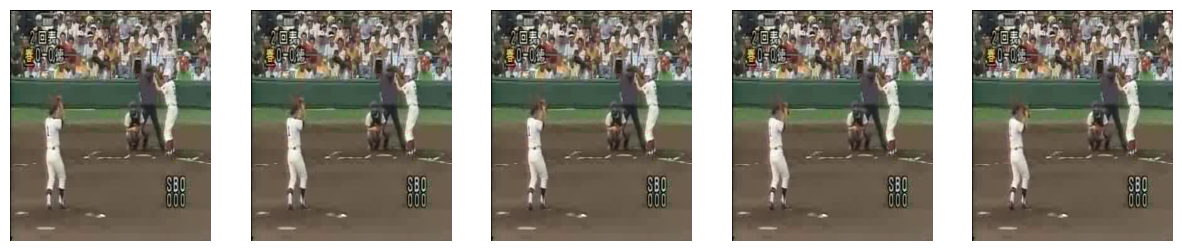

In [ ]:

checkpoint = torch.load('model_ResGRU2.pth',map_location = torch.device('cpu') )

model = ResNetGRU(101)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
with torch.no_grad():
  try:
    for inputs,labels in test_loader:
                print('Testing the model may take a while')
                inputs= inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                probabilities = torch.softmax(outputs, dim=1)

                # Find the predicted classes
                predicted = torch.argmax(probabilities, dim=1)
                # Get the probability of the predicted class
                predicted_prob = probabilities[0, predicted[0]].item()

                # Print actual and predicted labels and probabilities
                print(f"Actual label: {ucf101_labels[labels[0].item()]}")
                print(f"Predicted classification of the video: {ucf101_labels[predicted[0].item()]} with probability {predicted_prob:.4f}")


                # Display video frames
                show_video_frames(inputs)

                break
  except RuntimeError as e:

    print(f'Failed to test the model ')
    print(f'Error: {e}')
    pass



Some frames may seems like same images, however they are totally different with minor changes. Suggest you to re-run !
Secondly, Sometimes it gives wrong prediction in this model- accuracy is 0.50.